In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=b066a0470078b688bcee2c8960fbab02dca3ca2d3b03a60047ad33c000de5dbf
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=eb978e59f80a473b62bad11e65b26ff29da3f09f7890446aab8cbb0513d4c8fd
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f53

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [2]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 16.19 MiB/s, done.


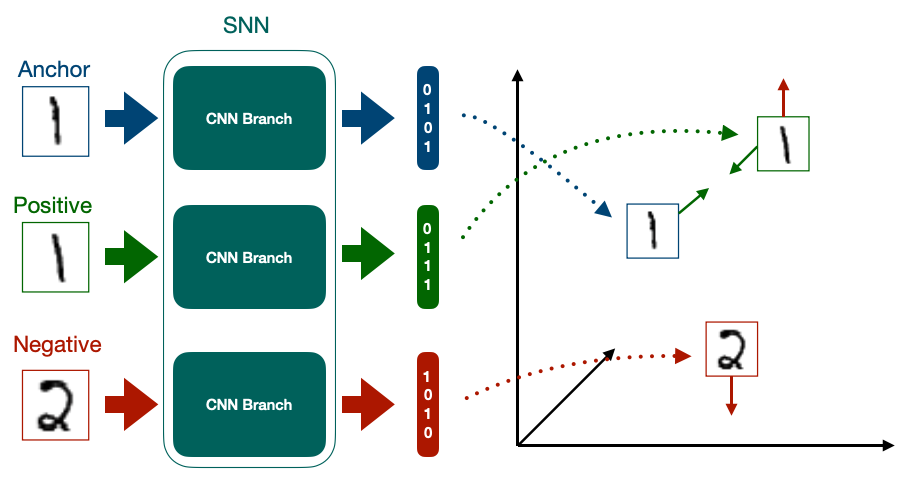

# Imports

In [3]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [5]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = 'cuda'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [7]:
row = df.iloc[4]

A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

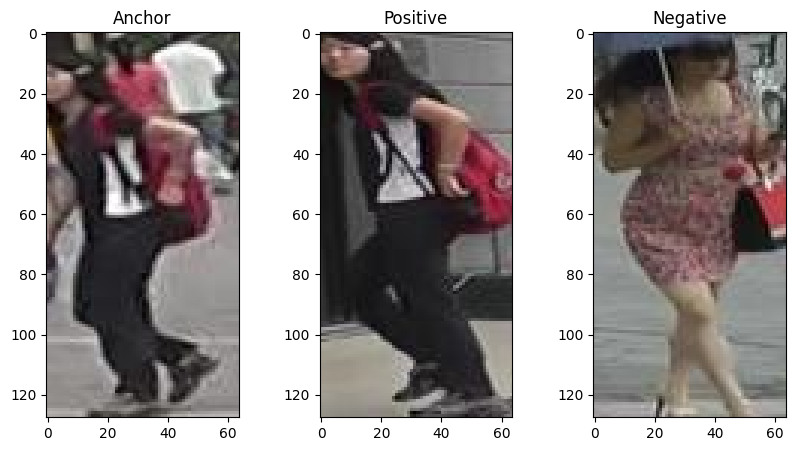

In [8]:
f, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(10, 5))

ax1.set_title('Anchor')
ax1.imshow(A_img)

ax2.set_title('Positive')
ax2.imshow(P_img)

ax3.set_title('Negative')
ax3.imshow(N_img)

In [9]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

# Create APN Dataset

In [10]:
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx) :
    row = self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)

    A_img = torch.from_numpy(A_img).permute(2,0,1)/255.0
    P_img = torch.from_numpy(P_img).permute(2,0,1)/255.0
    N_img = torch.from_numpy(N_img).permute(2,0,1)/255.0

    return A_img, P_img, N_img

In [11]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f'Size of trainset : {len(trainset)}')
print(f'Size of validset : {len(validset)}')

Size of trainset : 3200
Size of validset : 800


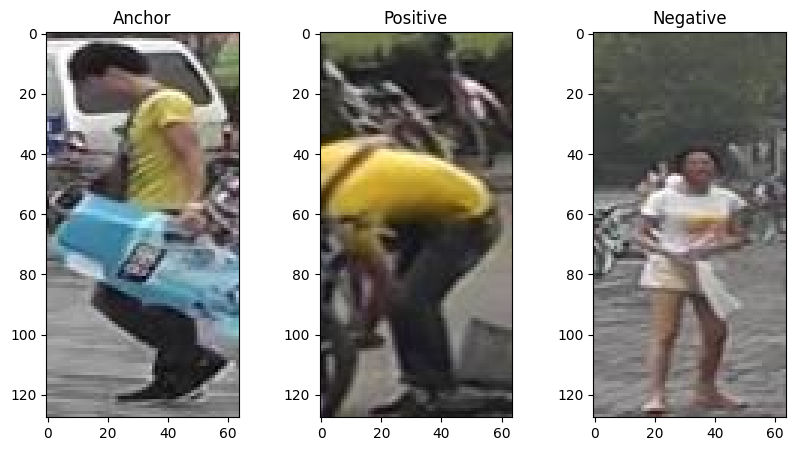

In [12]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [13]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [14]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [15]:
for A, P, N in trainloader:
  break

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [16]:
class APN_Model(nn.Module):

  def __init__(self, emb_size=512):
    super(APN_Model, self).__init__()

    self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):

    embeddings = self.efficientnet(images)
    return embeddings

In [17]:
model = APN_Model()
model.to(DEVICE);

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

# Create Train and Eval function

In [18]:
def train_fn(model, dataloader,optimizer, criterion):

  model.train() # ON Dropout
  total_loss = 0.0

  for A,P,N in tqdm(dataloader):

    A,P,N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss/len(dataloader)


In [19]:
def eval_fn(model, dataloader, criterion):

  model.eval() # OFF Dropout
  total_loss = 0.0

  with torch.no_grad():
    for A,P,N in tqdm(dataloader):

      A,P,N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()
    return total_loss/len(dataloader)

In [20]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Create Training Loop

In [21]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print('SAVED_WEIGHTS_SUCCESS')

  print(f'EPOCHS : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}')

100%|██████████| 25/25 [00:02<00:00, 10.98it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 1 train_loss : 0.5774581682682037 valid_loss : 0.586501077413559


100%|██████████| 25/25 [00:02<00:00, 11.23it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 2 train_loss : 0.23602679789066314 valid_loss : 0.27502147257328036


100%|██████████| 25/25 [00:02<00:00,  9.82it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 3 train_loss : 0.16167913362383843 valid_loss : 0.2613172936439514


100%|██████████| 25/25 [00:02<00:00, 11.05it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 4 train_loss : 0.14800089910626413 valid_loss : 0.2386608302593231


100%|██████████| 25/25 [00:02<00:00, 10.67it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 5 train_loss : 0.1278258562833071 valid_loss : 0.17788383543491362


100%|██████████| 25/25 [00:02<00:00,  9.88it/s]


EPOCHS : 6 train_loss : 0.07372167840600014 valid_loss : 0.19197050243616104


100%|██████████| 25/25 [00:02<00:00, 11.09it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 7 train_loss : 0.05585204362869263 valid_loss : 0.16779328584671022


100%|██████████| 25/25 [00:02<00:00, 10.00it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 8 train_loss : 0.04507632970809936 valid_loss : 0.1391735017299652


100%|██████████| 25/25 [00:02<00:00, 10.92it/s]


EPOCHS : 9 train_loss : 0.03436280645430088 valid_loss : 0.1885909616947174


100%|██████████| 25/25 [00:02<00:00, 10.82it/s]


EPOCHS : 10 train_loss : 0.03928529486060142 valid_loss : 0.18041791379451752


100%|██████████| 25/25 [00:02<00:00,  8.74it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 11 train_loss : 0.04933858789503574 valid_loss : 0.12823399603366853


100%|██████████| 25/25 [00:02<00:00, 10.64it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 12 train_loss : 0.02983516663312912 valid_loss : 0.09614621043205261


100%|██████████| 25/25 [00:02<00:00, 10.93it/s]


EPOCHS : 13 train_loss : 0.029201097637414932 valid_loss : 0.133979649245739


100%|██████████| 25/25 [00:02<00:00,  8.36it/s]


EPOCHS : 14 train_loss : 0.029066148847341537 valid_loss : 0.13480920732021331


100%|██████████| 25/25 [00:02<00:00, 11.01it/s]

SAVED_WEIGHTS_SUCCESS
EPOCHS : 15 train_loss : 0.03298267051577568 valid_loss : 0.09074176788330078


# Get Anchor Embeddings

In [22]:
def get_encoding_csv(anc_img_model, anc_img_names):

  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR+i)
      A = torch.from_numpy(A).permute(2,0,1)/255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)

    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

  return df_enc

In [23]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

100%|██████████| 4000/4000 [00:46<00:00, 86.15it/s]


In [24]:
df_enc.to_csv('database.csv', index=False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.022713,1.054903,-0.290948,0.065431,-0.512640,-0.032384,0.032264,0.040835,0.050435,...,0.010522,0.612034,0.383110,-0.396319,-0.179802,0.002387,0.158748,0.815395,-0.117261,-0.243547
1,1420_c3s3_061978_03.jpg,-0.223246,1.134631,-0.555738,-0.364523,-0.538955,0.287456,-0.285871,0.283867,0.025033,...,0.347095,0.251998,0.298939,-0.629135,-0.538577,0.125181,0.728712,0.473705,0.182576,-0.512014
2,1420_c5s3_062565_05.jpg,0.581502,0.953515,-0.343594,-0.431121,-0.319945,-0.015382,0.025754,0.146244,0.365027,...,0.340856,0.661370,0.556353,-0.380977,-0.187109,-0.004422,0.065048,0.194272,0.065505,-0.449461
3,1420_c6s3_085592_04.jpg,0.311812,1.088824,0.143923,-0.040148,0.080295,-0.079565,0.143241,-0.052456,0.130030,...,0.378554,0.968080,0.156691,-0.725339,0.194281,0.248614,0.428707,-0.097982,-0.091118,-0.422558
4,0663_c5s3_085987_03.jpg,0.845623,0.202237,0.595954,-0.301006,0.901206,-0.155636,0.681676,-0.488628,-0.039124,...,-0.080874,0.170237,0.158912,0.480751,0.678362,-0.466195,0.022962,-1.311713,0.295969,-0.318975


# Inference

In [25]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc - anc_enc_arr).T))
  return dist

In [27]:
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2,0,1)/255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [28]:
anc_enc_arr = df_enc.iloc[:,1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [29]:
distance = []

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i:i+1,:])
  distance = np.append(distance, dist)

In [30]:
closest_idx = np.argsort(distance)

/usr/local/lib/python3.10/dist-packages/networkx/drawing/layout.py:724: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


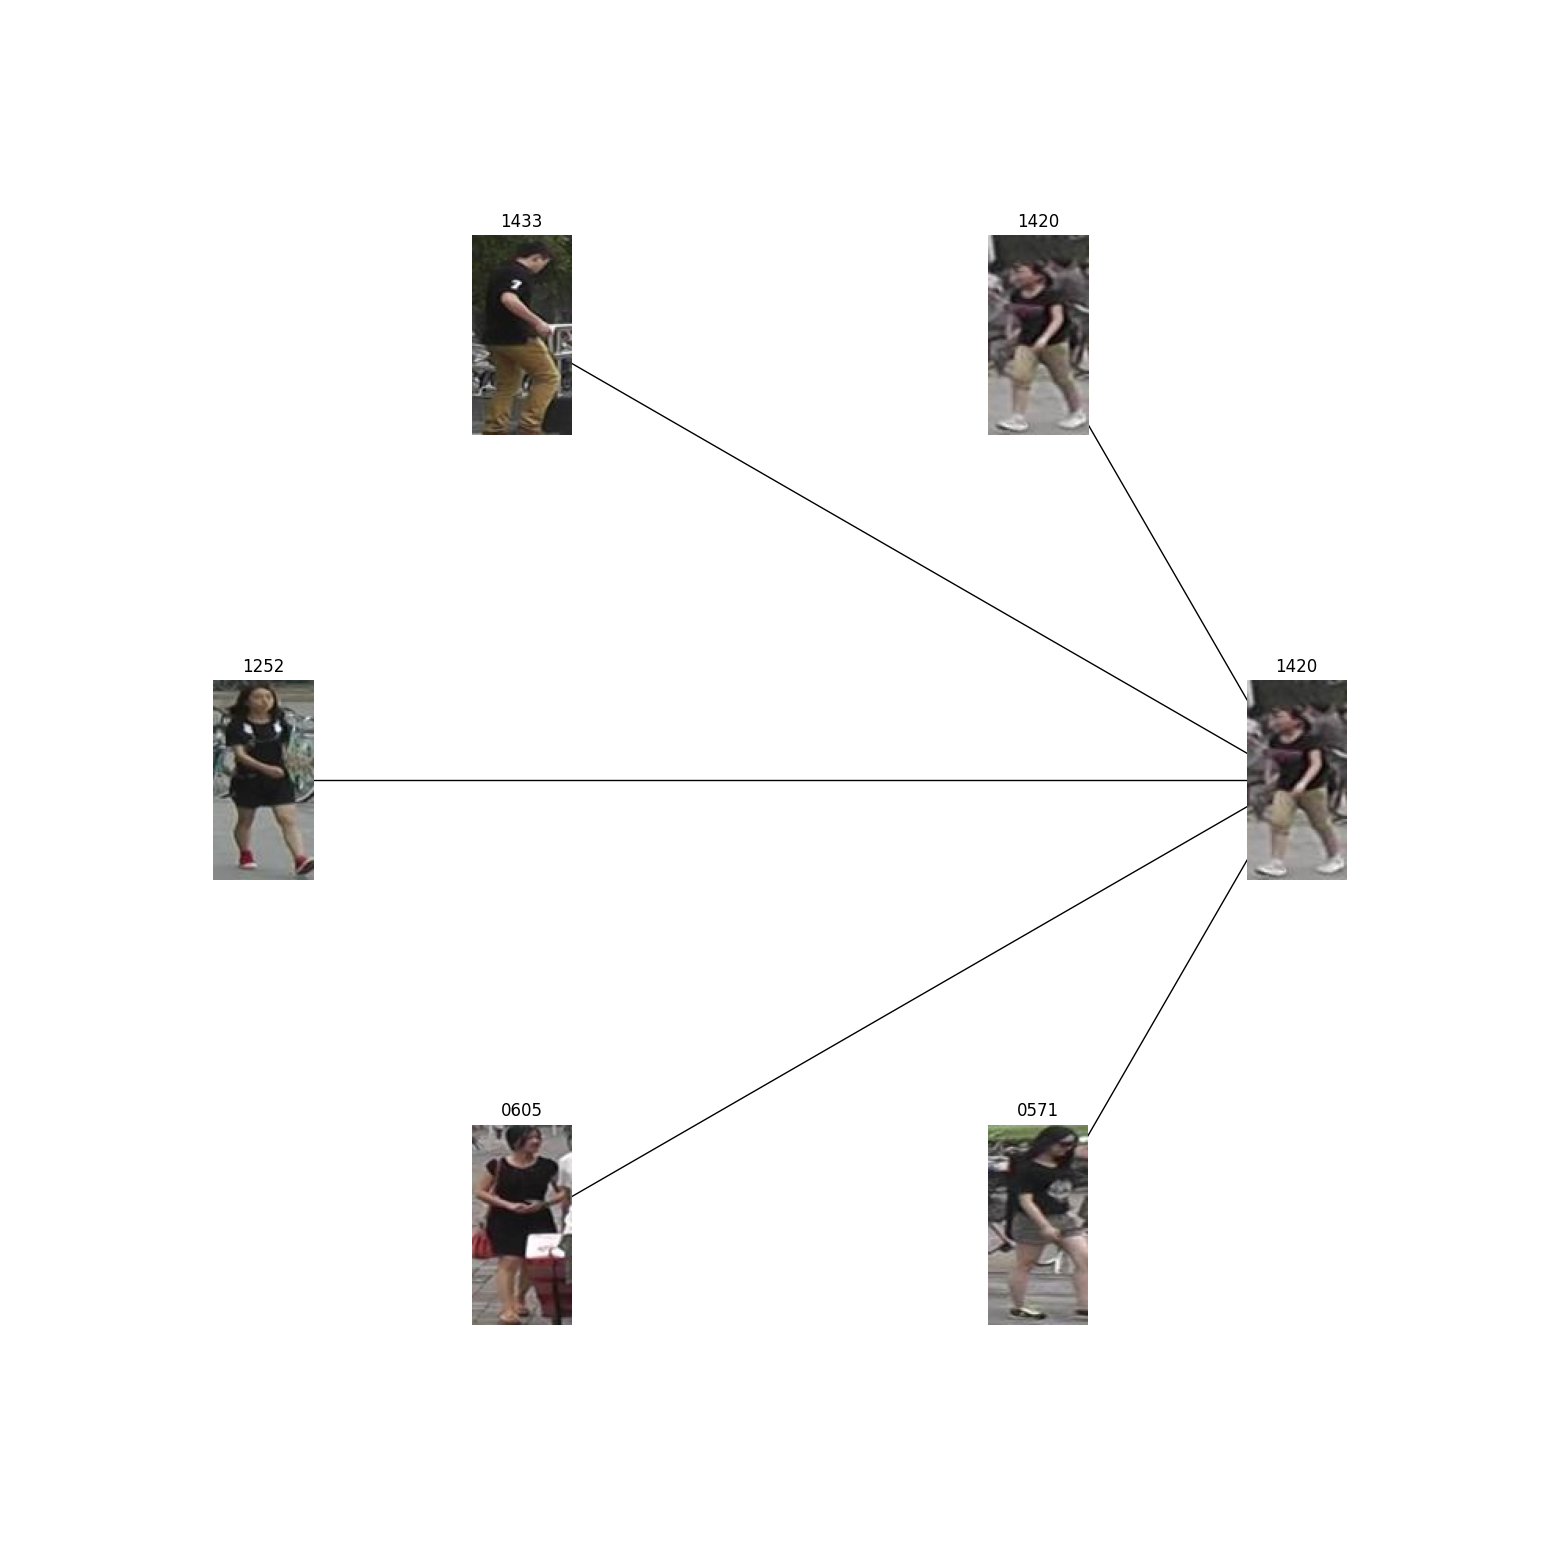

In [31]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);